In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import plotly.express as px
import plotly.figure_factory as ff
from arch import arch_model

from ipywidgets import HBox, VBox
from scipy.optimize import fmin, minimize
from scipy.stats import t
from scipy.stats import norm
from math import inf

import bs4 as bs
import requests
import yfinance as yf
import datetime

from scipy.stats import gamma
from scipy.stats import norm
from scipy.stats import t
from scipy.stats import beta
import matplotlib.pyplot as plt

# Introducing Copulas
## Bivariate normal - What we all do using correlation

In [2]:
np.random.seed(seed=5)
mean = [0,0]
rho = 0.8
cov = [[1,rho],[rho,1]] # diagonal covariance, points lie on x or y-axis

norm_1,norm_2 = np.random.multivariate_normal(mean,cov,1000).T
unif_1 = norm.cdf(norm_1)
unif_2 = norm.cdf(norm_2)

In [4]:
norm_data = pd.concat([pd.DataFrame(norm_1), pd.DataFrame(norm_2)], axis=1)
norm_data.columns = ['X', 'Y']
norm_data.corr()

,X,Y
X,1.000000,0.803551
Y,0.803551,1.000000


In [5]:
fig = px.scatter(norm_data, x = 'X', y='Y', width=700, height=500, trendline='ols', trendline_color_override='DeepPink', marginal_x='histogram', marginal_y='histogram', title='Bi-Variate Normal')
fig.show()

## We will use a Copula here, which allows us to use time series with different distributions. An example of this would be trying to work out the correlation between time spent on Amazon, and money spent.
# Time spent on website

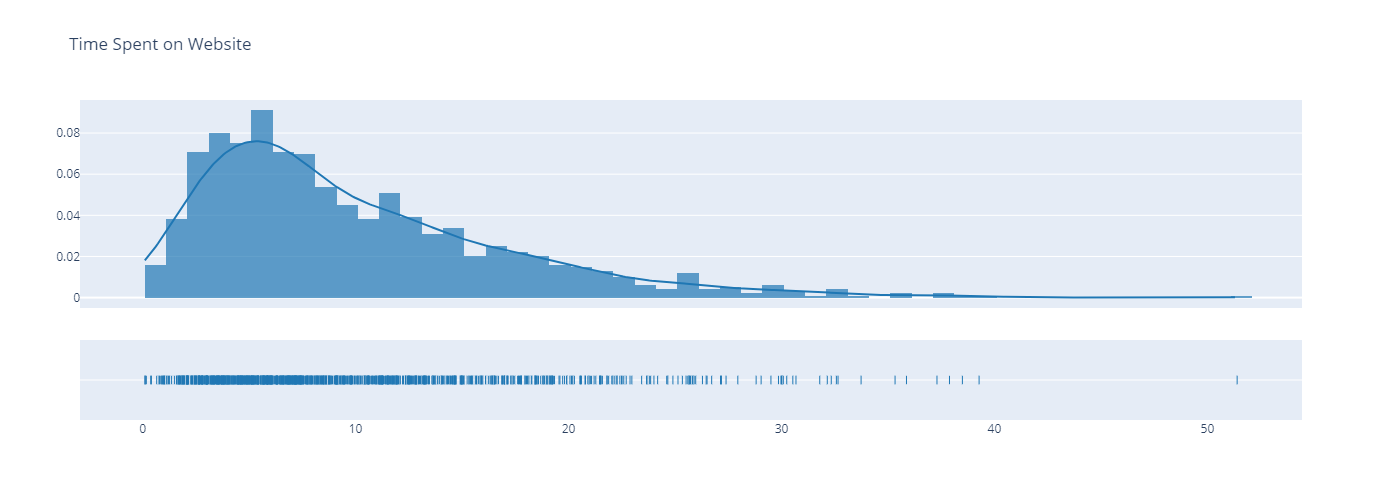

In [6]:
website_time = pd.DataFrame(gamma.ppf(unif_1, a=2, scale=5))
website_spend =  pd.DataFrame(beta.ppf(unif_2,a=0.5, b=0.5, loc=5, scale=100))
join_time_spend = pd.concat([website_time, website_spend], axis=1)
join_time_spend.columns = ['Time', 'Cash']
gamma_dist  = ff.create_distplot([website_time.values.reshape(-1)], group_labels = [' '])
gamma_dist.update_layout(showlegend=False, title_text='Time Spent on Website', width=1000, height=500)
gamma_dist.show()

## Dollars spent on website

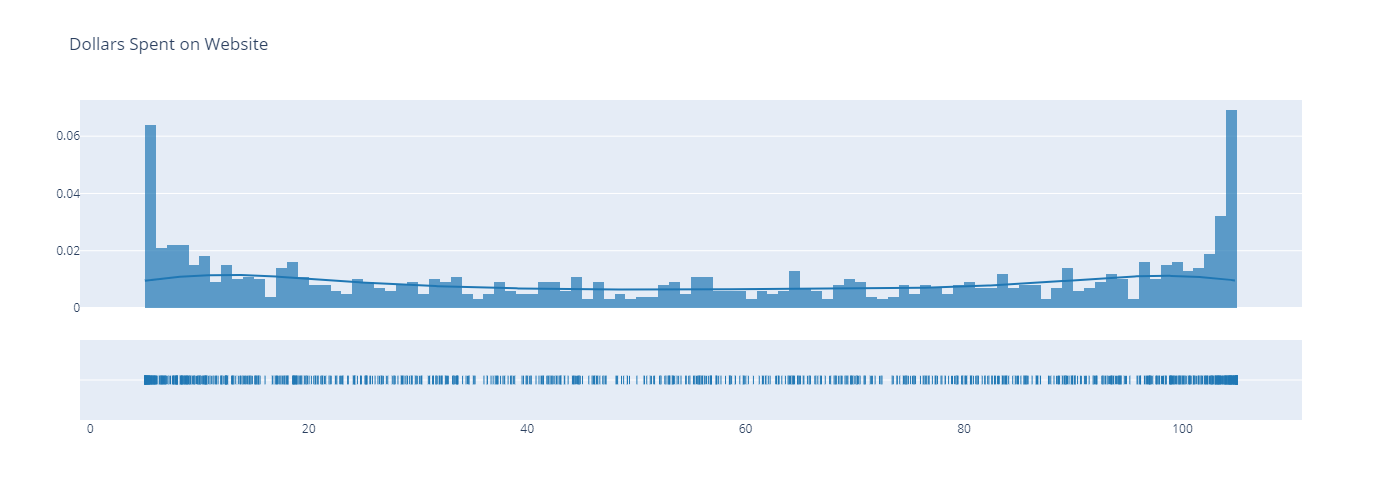

In [7]:
t_dist  = ff.create_distplot([website_spend.values.reshape(-1)], group_labels = [' '])
t_dist.update_layout(showlegend=False, title_text='Dollars Spent on Website', width=1000, height=500)
t_dist.show()

## Scatter plot of time spent on website vs $$ spent

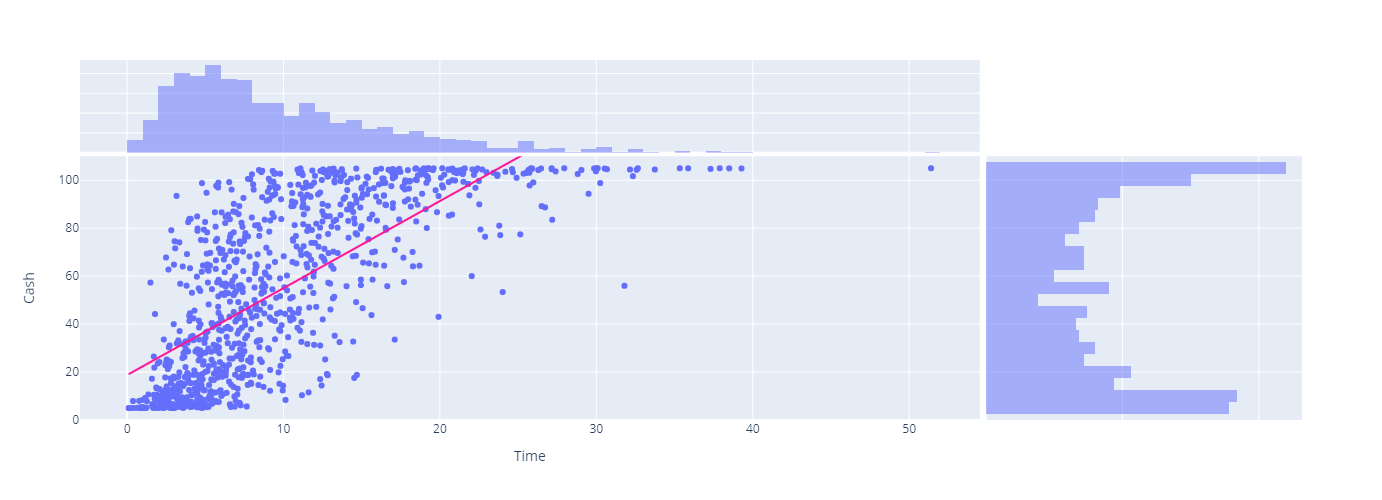

In [8]:
fig = px.scatter(join_time_spend, x = 'Time', y='Cash', width=1000, height=500,  range_y=[0,110], trendline='ols', trendline_color_override='DeepPink',  marginal_x='histogram', marginal_y='histogram')
fig.show()

In [9]:
print("Corrlation between time and $$ is: " + str(round(join_time_spend.corr().values[0][1],4)))

Corrlation between time and $$ is: 0.7231


## Transforming distributions to make our lives easier

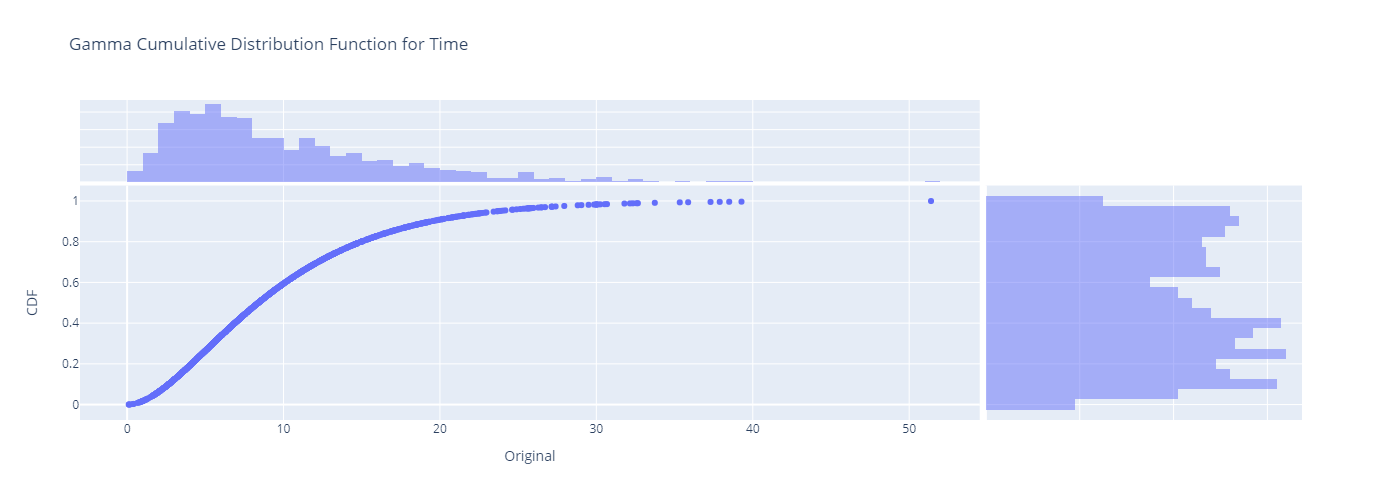

In [10]:
time_cdf =  pd.DataFrame(gamma.cdf(website_time.values, a = 2, scale=5))
time_cdf_vs_original = pd.concat([time_cdf, website_time], axis=1)
time_cdf_vs_original.columns = ['CDF', 'Original']

time_cdf_vs_original_plot = px.scatter(time_cdf_vs_original, x = 'Original', y='CDF', width=1000, height=500, title='Gamma Cumulative Distribution Function for Time',  marginal_x='histogram', marginal_y='histogram')
time_cdf_vs_original_plot.show()

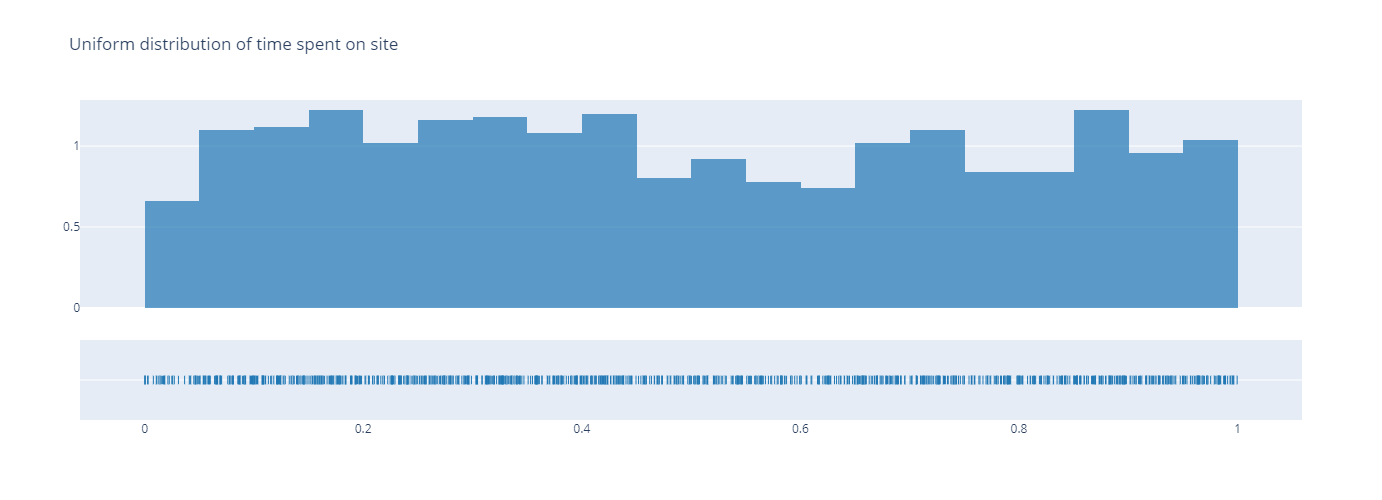

In [11]:
time_cdf =  pd.DataFrame(gamma.cdf(website_time.values, a = 2, scale=5))
time_cdf_plot  = ff.create_distplot([time_cdf.values.reshape(-1)], group_labels = [' '], show_curve=False, bin_size=0.05)
time_cdf_plot.update_layout(showlegend=False, title_text='Uniform distribution of time spent on site', width=1000, height=500)
time_cdf_plot.show()

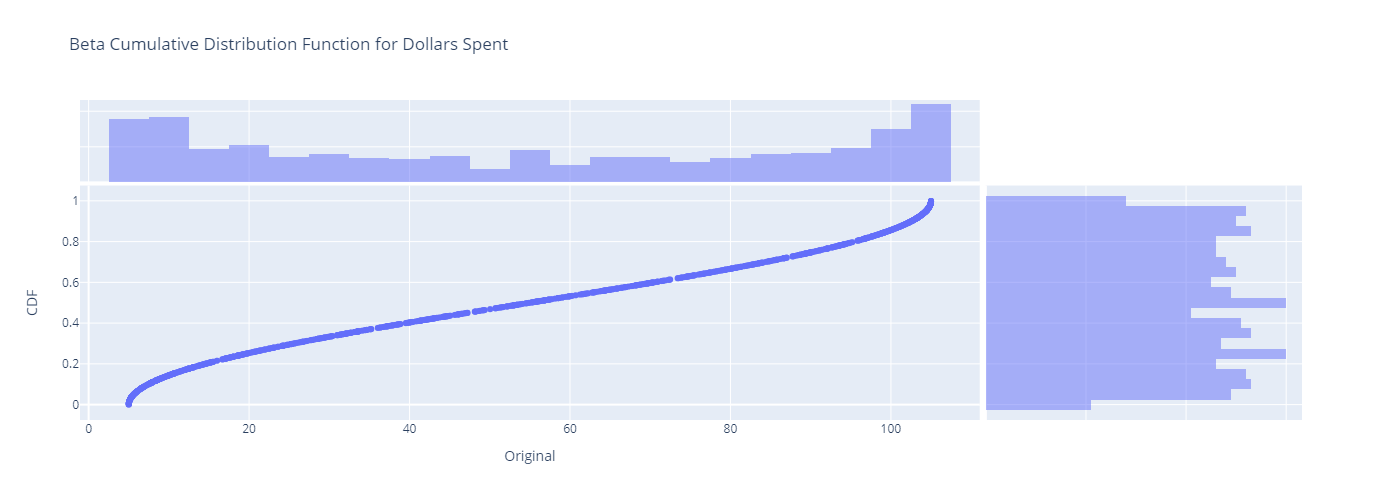

In [12]:
dollar_cdf = pd.DataFrame(beta.cdf(website_spend.values,a=0.5, b=0.5, loc=5, scale=100))
dollar_cdf_vs_original = pd.concat([dollar_cdf, website_spend], axis=1)
dollar_cdf_vs_original.columns = ['CDF', 'Original']

dollar_cdf_vs_original_plot = px.scatter(dollar_cdf_vs_original, x = 'Original', y='CDF', width=1000, height=500, title='Beta Cumulative Distribution Function for Dollars Spent',  marginal_x='histogram', marginal_y='histogram')
dollar_cdf_vs_original_plot.show()

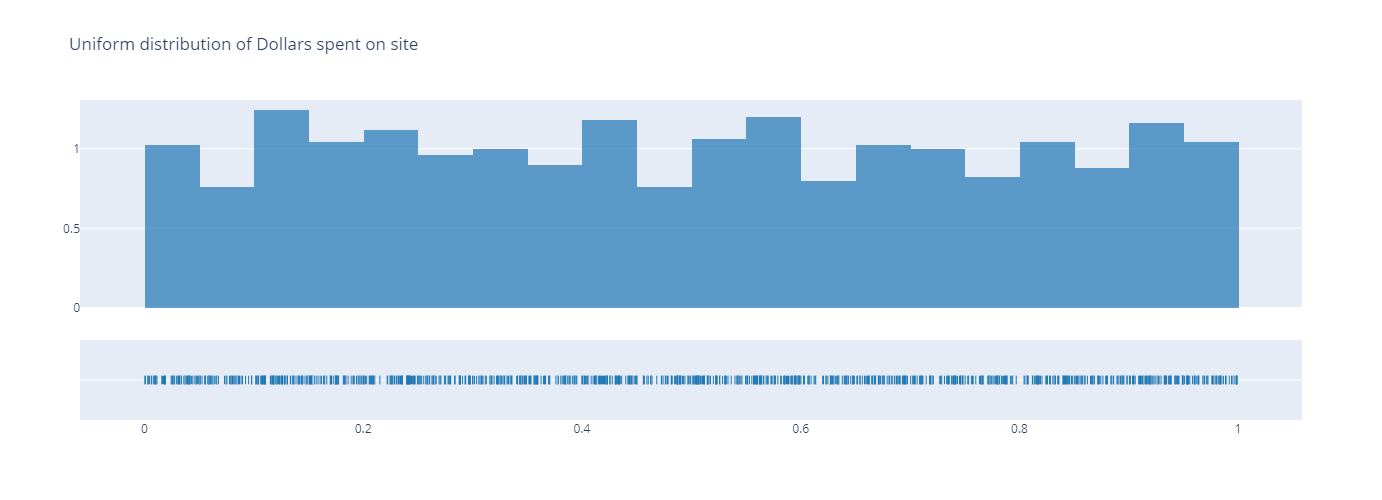

In [13]:
dollar_cdf_plot  = ff.create_distplot([dollar_cdf.values.reshape(-1)], group_labels = [' '], show_curve=False, bin_size=0.05)
dollar_cdf_plot.update_layout(showlegend=False, title_text='Uniform distribution of Dollars spent on site', width=1000, height=500)
dollar_cdf_plot.show()

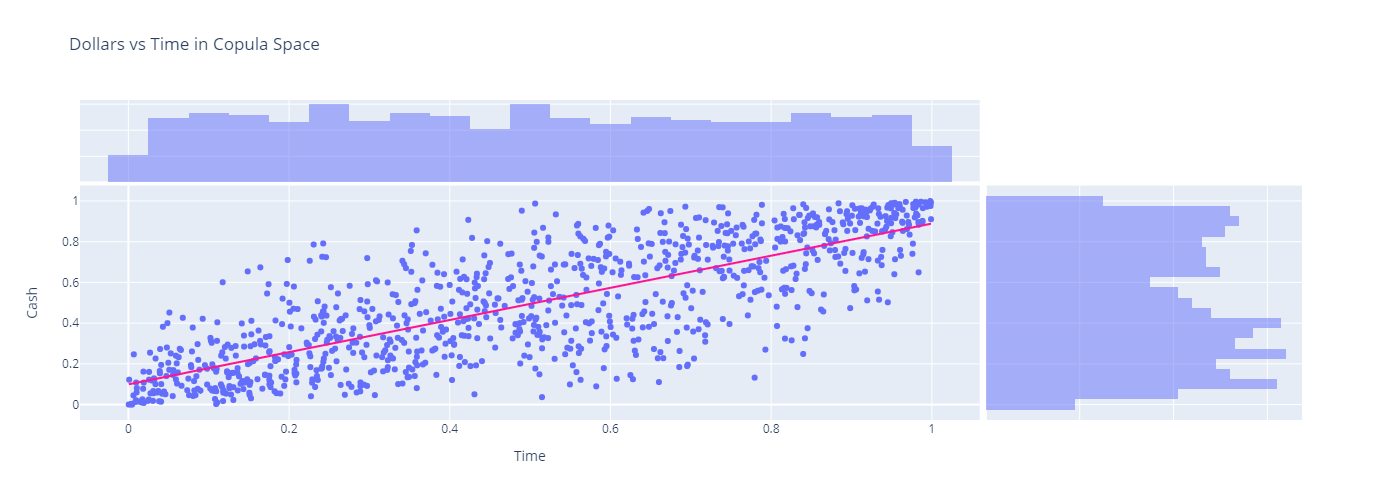

In [17]:
join_time_spend_uniform = pd.concat([dollar_cdf, time_cdf], axis=1)
join_time_spend_uniform.columns = ['Time', 'Cash']

time_v_money_uniform = px.scatter(join_time_spend_uniform, x = 'Time', y='Cash', width=1000, height=500,  marginal_x='histogram', marginal_y='histogram', title='Dollars vs Time in Copula Space', trendline='ols', trendline_color_override='DeepPink', )
time_v_money_uniform.show()

In [18]:
print("Corrlation between uniform time and $$ is: " + str(round(join_time_spend_uniform.corr().values[0][1],4)))

Corrlation between uniform time and $$ is: 0.7933


# Examples of popular copulas
<img width=800 height=800 src="copulas.png"/>

            0         1
0    0.189520  0.425035
1    0.636769  0.447542
2    0.824753  0.677088
3    0.704811  0.802279
4    0.886422  0.777970
..        ...       ...
995  0.391900  0.988325
996  0.493090  0.894554
997  0.646151  0.911908
998  0.298377  0.129599
999  0.298462  0.343895

[1000 rows x 2 columns]


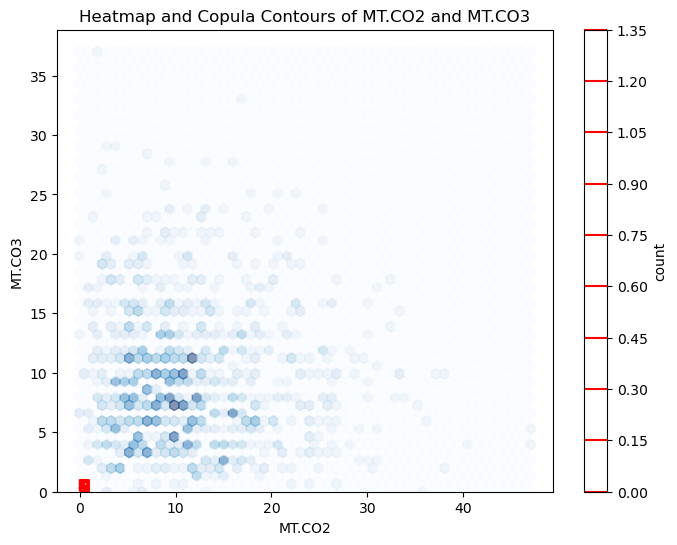

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde
from statsmodels.distributions.empirical_distribution import ECDF
from copulas.multivariate import GaussianMultivariate

# Set the seed for reproducibility
np.random.seed(42)

# Generate two sets of negative binomial data
n = 1000
size1, prob1 = 3, 0.2
size2, prob2 = 4, 0.3

mt_co2 = np.random.negative_binomial(size1, prob1, n)
mt_co3 = np.random.negative_binomial(size2, prob2, n)

# Transform to uniform distributions using the empirical CDF
ecdf1 = ECDF(mt_co2)
ecdf2 = ECDF(mt_co3)

u1 = ecdf1(mt_co2)
u2 = ecdf2(mt_co3)

# Combine the uniform distributions into a matrix
uniform_data = np.column_stack((u1, u2))

# Fit a Gaussian copula to the data
copula = GaussianMultivariate()
copula.fit(uniform_data)

# Sample from the copula to get uniform marginals
uniform_sample = copula.sample(n)

# Extract uniform marginals
print(uniform_sample)
u1_sample, u2_sample = uniform_sample[0], uniform_sample[1]

# Create a meshgrid for the contour plot
X, Y = np.mgrid[0:1:100j, 0:1:100j]
positions = np.vstack([X.ravel(), Y.ravel()])

# Kernel Density Estimation on uniform marginals
values = np.vstack([u1_sample, u2_sample])
kernel = gaussian_kde(values)
Z = np.reshape(kernel(positions).T, X.shape)

# Plot the scatter plot and the copula contours
plt.figure(figsize=(8, 6))

# Create scatter plot
plt.hexbin(mt_co2, mt_co3, gridsize=50, cmap='Blues', alpha=0.5)

# Overlay the contour plot
plt.contour(X, Y, Z, colors='red')

plt.title('Heatmap and Copula Contours of MT.CO2 and MT.CO3')
plt.xlabel('MT.CO2')
plt.ylabel('MT.CO3')
plt.colorbar(label='count')
plt.show()

